# Clustering: Lab 3

In [1]:
import numpy as np
import os
from sklearn.datasets import load_iris
# !pip install yellowbrick
import yellowbrick

seed = 42
np.random.seed(seed)

# To plot pretty figures
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

Classification vs Clustering

In [2]:
data = load_iris()
X = data.data
y = data.target
data.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

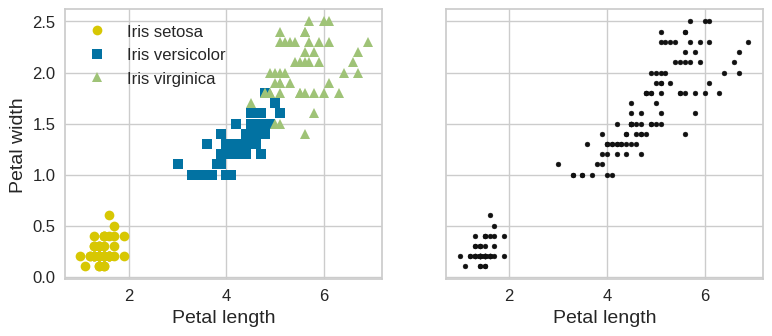

In [3]:
plt.figure(figsize=(9, 3.5))

plt.subplot(121)
plt.plot(X[y==0, 2], X[y==0, 3], "yo", label="Iris setosa")
plt.plot(X[y==1, 2], X[y==1, 3], "bs", label="Iris versicolor")
plt.plot(X[y==2, 2], X[y==2, 3], "g^", label="Iris virginica")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(fontsize=12)

plt.subplot(122)
plt.scatter(X[:, 2], X[:, 3], c="k", marker=".")
plt.xlabel("Petal length", fontsize=14)
plt.tick_params(labelleft=False)

plt.show()

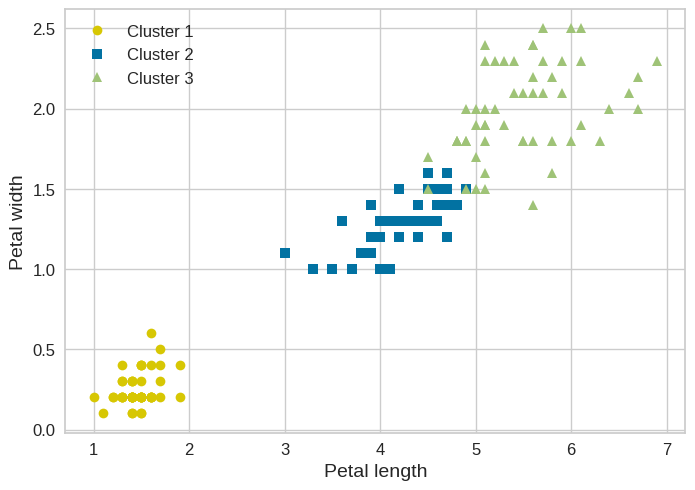

Number of total instances: 150
Number of correct assignments: 145
Correct assignment percentage: 97.0


In [4]:
# This cell is just an FYI and not an official part of the course contents.

# A Gaussian mixture model can actually separate these clusters pretty well
# (using all 4 features: petal length & width, and sepal length & width).

from sklearn.mixture import GaussianMixture

y_pred = GaussianMixture(n_components=3, random_state=seed).fit(X).predict(X)

# Let's map each cluster to a class. Instead of hard coding the mapping,
# we will pick the most common class for each cluster (using the `scipy.stats.mode()` function):
from scipy import stats

mapping = {}
for class_id in np.unique(y):
    mode, _ = stats.mode(y_pred[y==class_id], keepdims=True)
    mapping[mode[0]] = class_id

y_pred = np.array([mapping[cluster_id] for cluster_id in y_pred])

# plotting
plt.plot(X[y_pred==0, 2], X[y_pred==0, 3], "yo", label="Cluster 1")
plt.plot(X[y_pred==1, 2], X[y_pred==1, 3], "bs", label="Cluster 2")
plt.plot(X[y_pred==2, 2], X[y_pred==2, 3], "g^", label="Cluster 3")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=12)
plt.show()

print('Number of total instances:', len(y_pred))
print('Number of correct assignments:',np.sum(y_pred==y))
print('Correct assignment percentage:', (np.sum(y_pred==y) / len(y_pred)).round(2)*100)

# End of FYI.

## K-Means

In [5]:
# Let's start by generating some blobs:
from sklearn.datasets import make_blobs

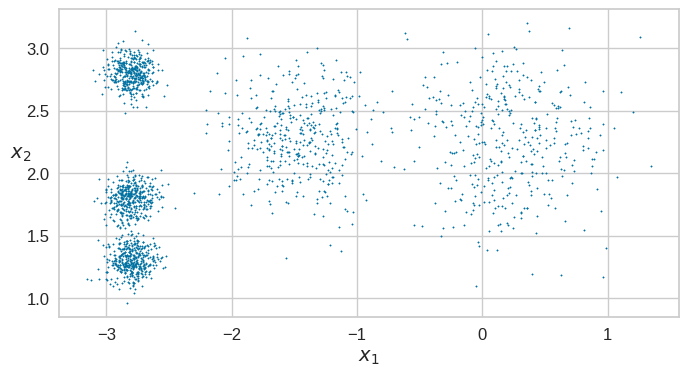

In [6]:
blob_centers = np.array(
    [[ 0.2,  2.3],
     [-1.5 ,  2.3],
     [-2.8,  1.8],
     [-2.8,  2.8],
     [-2.8,  1.3]])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])

X, y = make_blobs(n_samples=2000, centers=blob_centers, cluster_std=blob_std, random_state=7)

# plotting
def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)
plt.figure(figsize=(8, 4))
plot_clusters(X)
plt.show()

In [7]:
# Fit and predict
# Let's train a K-Means clusterer on this dataset.
# It will try to find each blob's center and assign each instance to the closest blob:
from sklearn.cluster import KMeans

k = 5
kmeans = KMeans(n_clusters=k, random_state=seed)
y_pred = kmeans.fit_predict(X)

print('Each instance was assigned to one of the k clusters', y_pred)

# Nota Bene: In clustering "label" is the index of the cluster that an instance gets assigned to by
# the algorithm (not to be mistaken with the other "label" that we know from supervised learning)

# The KMeans instance preserves a copy of the labels of the
# instances it was trained on, available via the `.labels_` attribute
print(y_pred is kmeans.labels_)

Each instance was assigned to one of the k clusters [4 0 1 ... 2 1 0]
True


In [8]:
# And the following k centroids (i.e., cluster centers) were estimated:
kmeans.cluster_centers_

array([[-2.80389616,  1.80117999],
       [ 0.20876306,  2.25551336],
       [-2.79290307,  2.79641063],
       [-1.46679593,  2.28585348],
       [-2.80037642,  1.30082566]])

In [9]:
# Let's predict the labels of some new instances:
X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])
kmeans.predict(X_new)

array([1, 1, 2, 2], dtype=int32)

**Decision Boundaries**

Let's plot the model's decision boundaries. This gives us a _Voronoi diagram_:

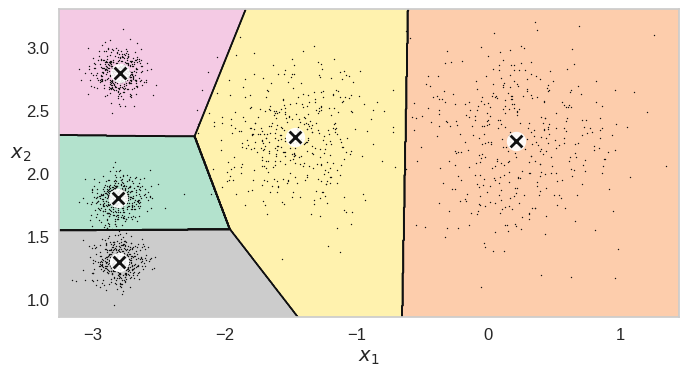

In [10]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True, show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution), np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]), cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]), linewidths=1, colors='k')
    plot_data(X)
    
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)
plt.show()

# Not bad! Some of the instances near the edges were probably
# assigned to the wrong cluster, but overall it looks pretty good.

**Hard Clustering _vs_ Soft Clustering**

Instead of assigning each instance to a single cluster, which is called hard clustering, it can be useful to give each instance a score per cluster, which is called soft clustering, aka Fuzzy clustering, (i.e., data points can belong to more than one cluster). The score can be the distance between the instance and the centroids. In the KMeans class, the `transform()` method measures that. There are methods such as Weighted K-Means utilizing this to perform soft clustering. Also, if you have a high-dimensional
dataset and you transform it this way, you end up with a `k`-dimensional dataset that for certain use cases can be a very efficient nonlinear dimensionality reduction technique.



In [11]:
kmeans.transform(X_new)

array([[2.81093633, 0.32995317, 2.9042344 , 1.49439034, 2.88633901],
       [5.80730058, 2.80290755, 5.84739223, 4.4759332 , 5.84236351],
       [1.21475352, 3.29399768, 0.29040966, 1.69136631, 1.71086031],
       [0.72581411, 3.21806371, 0.36159148, 1.54808703, 1.21567622]])

In [12]:
# You can verify that this is indeed the Euclidian distance between each instance and each centroid:
np.linalg.norm(np.tile(X_new, (1, k)).reshape(-1, k, 2) - kmeans.cluster_centers_, axis=2)

array([[2.81093633, 0.32995317, 2.9042344 , 1.49439034, 2.88633901],
       [5.80730058, 2.80290755, 5.84739223, 4.4759332 , 5.84236351],
       [1.21475352, 3.29399768, 0.29040966, 1.69136631, 1.71086031],
       [0.72581411, 3.21806371, 0.36159148, 1.54808703, 1.21567622]])

### The K-Means Algorithm

The K-Means algorithm is one of the fastest clustering algorithms, and also one of the simplest:
* First initialize $k$ centroids randomly: $k$ distinct instances are chosen randomly from the dataset and the centroids are placed at their locations.
* Repeat until convergence (i.e., until the centroids stop moving):
    * Assign each instance to the closest centroid.
    * Update the centroids to be the mean of the instances that are assigned to them.


The `KMeans` class applies an optimized algorithm by default. To get the original K-Means algorithm (for educational purposes only), you must set `init="random"`, `n_init=1` and `algorithm="full"`.

Let's run the K-Means algorithm for 1, 2 and 3 iterations, to see how the centroids move around:

In [13]:
kmeans_iter1 = KMeans(n_clusters=5, init="random", n_init=1, algorithm="full", max_iter=1, random_state=0)
kmeans_iter2 = KMeans(n_clusters=5, init="random", n_init=1, algorithm="full", max_iter=2, random_state=0)
kmeans_iter3 = KMeans(n_clusters=5, init="random", n_init=1, algorithm="full", max_iter=3, random_state=0)

kmeans_iter1.fit(X)
kmeans_iter2.fit(X)
kmeans_iter3.fit(X)

/home/alireza/ml/my_env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1318: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
/home/alireza/ml/my_env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1318: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
/home/alireza/ml/my_env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1318: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


KMeans(algorithm='full', init='random', max_iter=3, n_clusters=5, n_init=1,
       random_state=0)

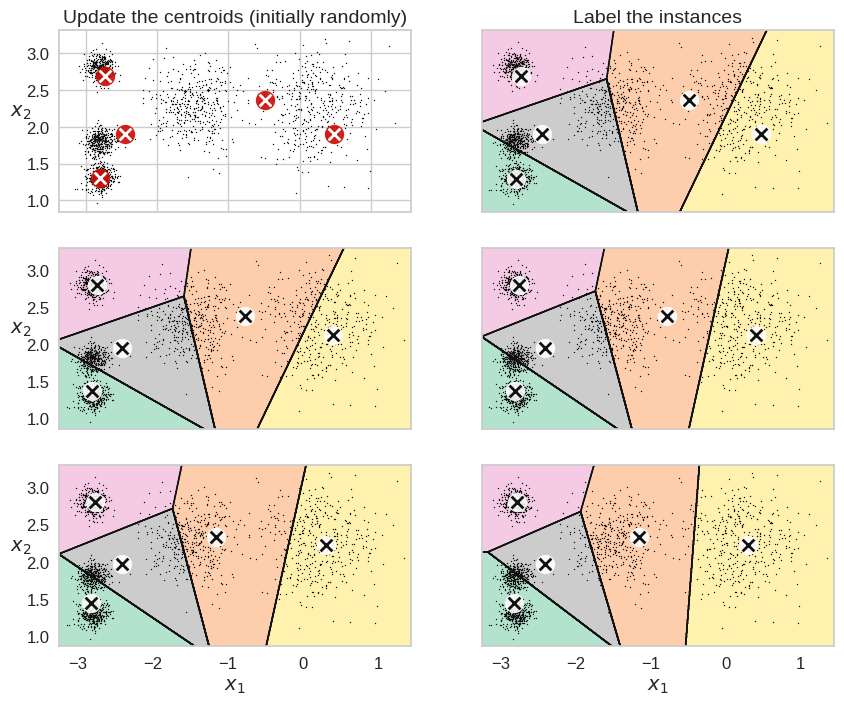

In [14]:
# And let's plot this:
plt.figure(figsize=(10, 8))

plt.subplot(321)
plot_data(X)
plot_centroids(kmeans_iter1.cluster_centers_, circle_color='r', cross_color='w')
plt.ylabel("$x_2$", fontsize=14, rotation=0)
plt.tick_params(labelbottom=False)
plt.title("Update the centroids (initially randomly)", fontsize=14)

plt.subplot(322)
plot_decision_boundaries(kmeans_iter1, X, show_xlabels=False, show_ylabels=False)
plt.title("Label the instances", fontsize=14)

plt.subplot(323)
plot_decision_boundaries(kmeans_iter1, X, show_centroids=False, show_xlabels=False)
plot_centroids(kmeans_iter2.cluster_centers_)

plt.subplot(324)
plot_decision_boundaries(kmeans_iter2, X, show_xlabels=False, show_ylabels=False)

plt.subplot(325)
plot_decision_boundaries(kmeans_iter2, X, show_centroids=False)
plot_centroids(kmeans_iter3.cluster_centers_)

plt.subplot(326)
plot_decision_boundaries(kmeans_iter3, X, show_ylabels=False)

plt.show()

### K-Means Variability

In the original K-Means algorithm, the centroids are just initialized randomly, and the algorithm simply runs a single iteration to gradually improve the centroids, as we saw above.

However, one major problem with this approach is that if you run K-Means multiple times (or with different random seeds), it can converge to very different solutions, as you can see below:

In [15]:
def plot_clusterer_comparison(clusterer1, clusterer2, X, title1=None, title2=None):
    clusterer1.fit(X)
    clusterer2.fit(X)

    plt.figure(figsize=(10, 3.2))

    plt.subplot(121)
    plot_decision_boundaries(clusterer1, X)
    if title1:
        plt.title(title1, fontsize=14)

    plt.subplot(122)
    plot_decision_boundaries(clusterer2, X, show_ylabels=False)
    if title2:
        plt.title(title2, fontsize=14)

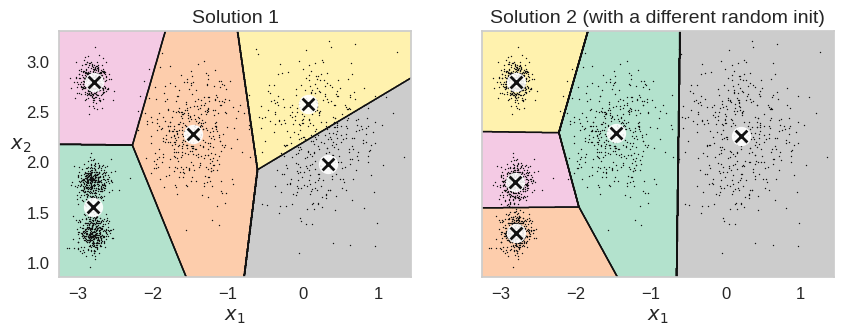

In [16]:
kmeans_rnd_init1 = KMeans(n_clusters=5, init="random", n_init=1, algorithm="lloyd", random_state=2)
kmeans_rnd_init2 = KMeans(n_clusters=5, init="random", n_init=1, algorithm="lloyd", random_state=5)

plot_clusterer_comparison(kmeans_rnd_init1, kmeans_rnd_init2, X, "Solution 1", "Solution 2 (with a different random init)")

plt.show()

### Finding the optimal number of clusters

#### Intertia score

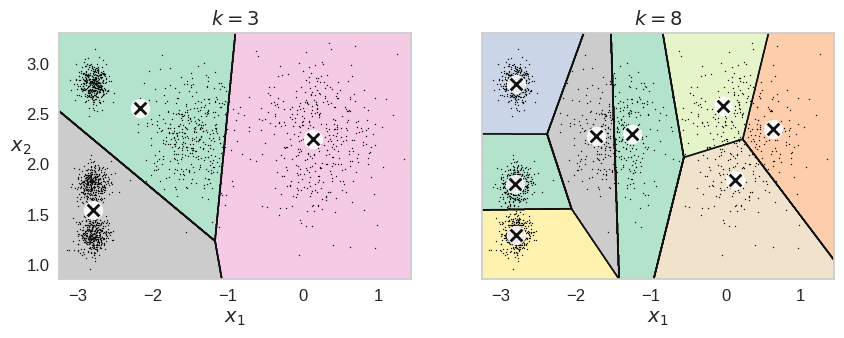

In [17]:
kmeans_k3 = KMeans(n_clusters=3, random_state=42)
kmeans_k8 = KMeans(n_clusters=8, random_state=42)

plot_clusterer_comparison(kmeans_k3, kmeans_k8, X, "$k=3$", "$k=8$")
plt.show()

In [18]:
print(kmeans_k3.inertia_)
print(kmeans_k8.inertia_)

653.2167190021552
119.11983416102879


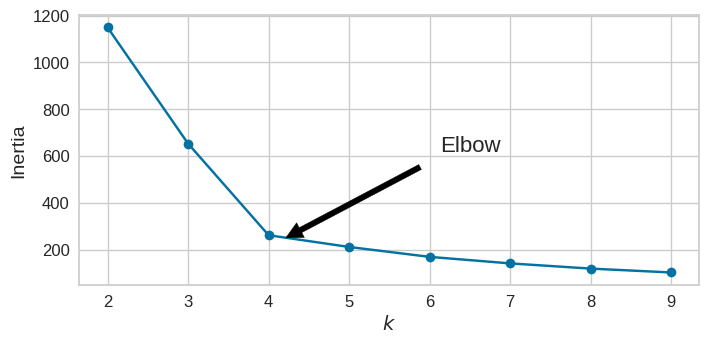

In [19]:
# We cannot simply take the value of k that minimizes the inertia, since it keeps getting lower as we increase k. 
# Indeed, the more clusters there are, the closer each instance will be to its closest centroid, and therefore the
# lower the inertia will be. However, we can plot the inertia as a function of k and analyze the resulting curve:
kmeans_per_k = [KMeans(n_clusters=k, random_state=seed).fit(X) for k in range(2, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

plt.figure(figsize=(8, 3.5))
plt.plot(range(2, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(4, inertias[3]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
# plt.axis([1, 8.5, 0, 1300])
plt.show()

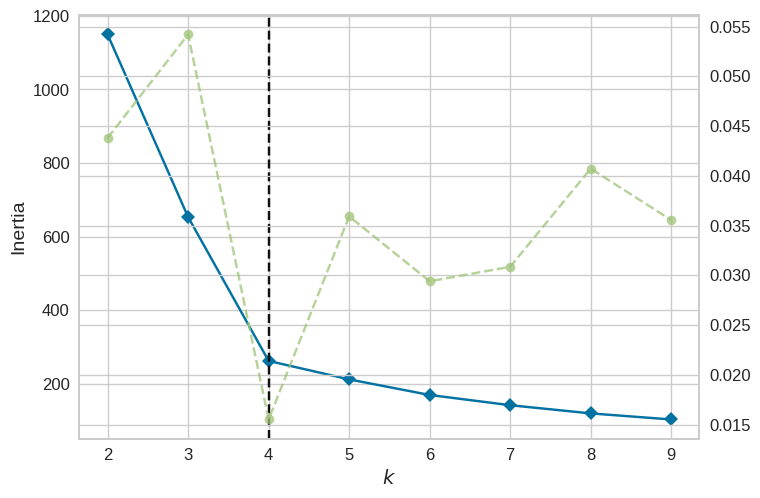

In [20]:
# A simpler way to plot Inertia score:

from yellowbrick.cluster import KElbowVisualizer

kmeans = KMeans(random_state=seed)

visualizer = KElbowVisualizer(kmeans, # Cluster model with any parameters you need
                              k=(2,10),   # Number of clusters to test (2 to 9 in this case)
                              locate_elbow=True, # Locate the elbow? Default is true.
                             )   

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.ax.set_xlabel("$k$")
visualizer.ax.set_ylabel("Inertia")
# visualizer.show()
plt.show()

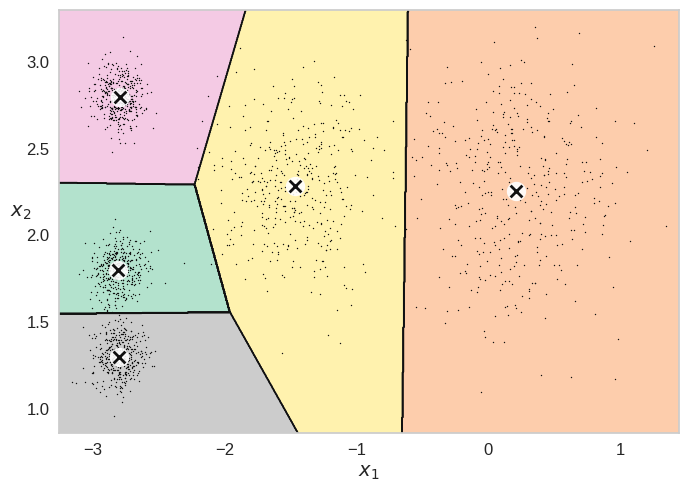

In [21]:
# As you can see, there is an elbow at k=4, which means that less clusters than that would be bad,
# and more clusters would not help much and might cut clusters in half. So k=4 is a pretty good choice.
# Of course in this example it is not perfect since it means that the two blobs in the lower left will
# be considered as just a single cluster, but it's a pretty good clustering nonetheless.
plot_decision_boundaries(kmeans_per_k[4-1], X)
plt.show()

#### Silhouette score

0.5668839323465226


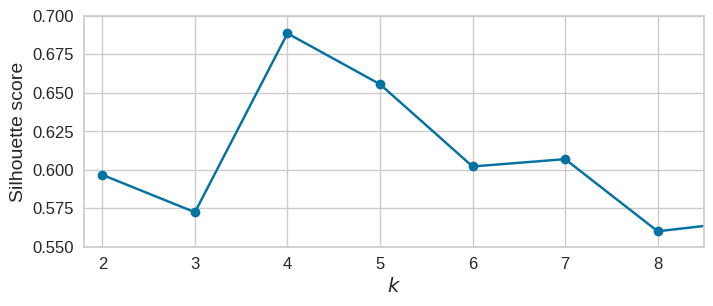

In [22]:
from sklearn.metrics import silhouette_score
print(silhouette_score(X, kmeans.labels_))

silhouette_scores = [silhouette_score(X, model.labels_) for model in kmeans_per_k[0:]]

plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.axis([1.8, 8.5, 0.55, 0.7])
plt.show()

# As you can see, this visualization is much richer than the inertia one:
# in particular, although it confirms that k=4 is a very good choice,
# but it also underlines the fact that k=5 is quite good as well.

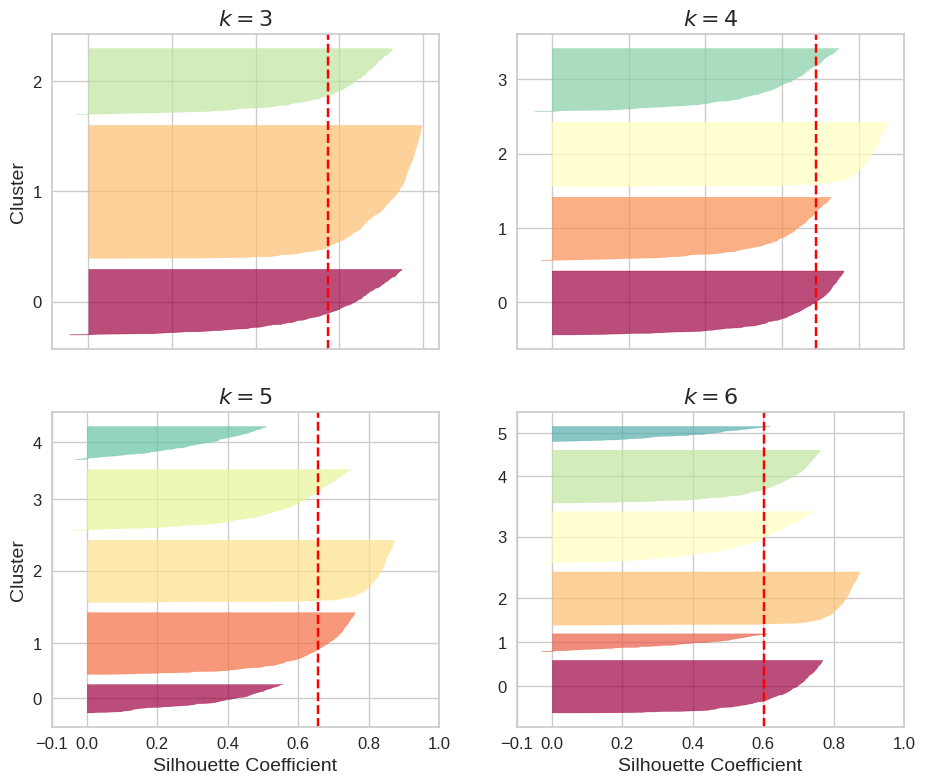

In [23]:
# We can make better judgment by looking at silhouette diagram

from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(11, 9))

for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)
    
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

plt.show()

# As you can see, k=5 looks like the best option here, as all clusters are roughly the same size,
# and they all cross the dashed line, which represents the mean silhouette score.

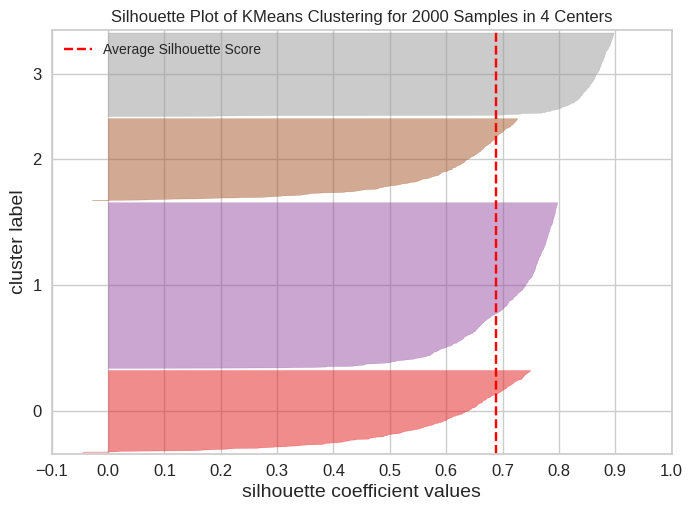

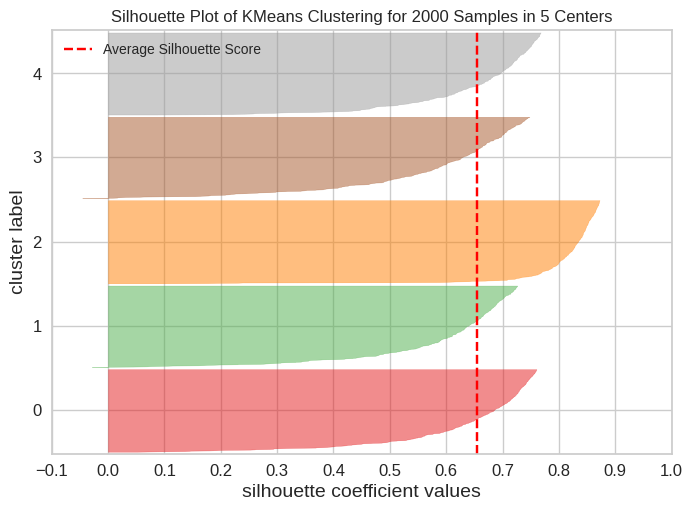

In [24]:
# A simpler way to plot Silhouette diagram:

from yellowbrick.cluster import SilhouetteVisualizer

for k in np.arange(4, 6):
  kmeans = KMeans(n_clusters=k, random_state=seed)
  visualizer = SilhouetteVisualizer(kmeans) # Get the clusterer model
  visualizer.fit(X) # Pass the data
  visualizer.show()
  plt.show()

## Limits of K-Means

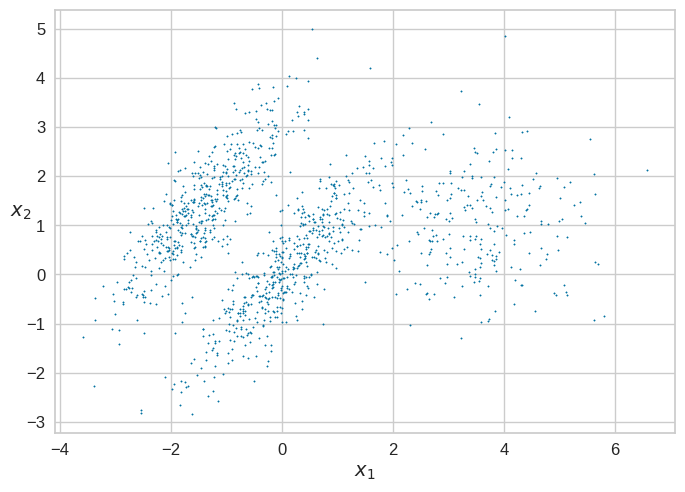

In [25]:
# Despite its many merits, most notably being fast and scalable, K-Means is not perfect. As we saw,
# it is necessary to run the algorithm several times to avoid suboptimal solutions, plus you need
# to specify the number of clusters, which can be quite a hassle. Moreover, K-Means does not behave
# very well when the clusters have varying sizes, different densities, or nonspherical shapes.

# The example below shows how K-Means clusters a dataset containing three ellipsoidal clusters
# of different dimensions, densities, and orientations.

X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]
plot_clusters(X)

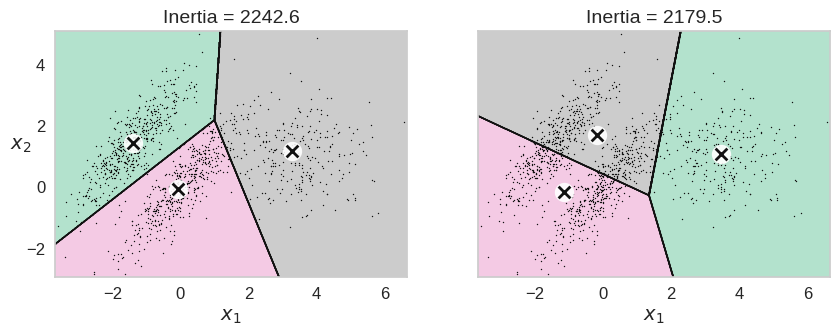

In [26]:
kmeans_good = KMeans(n_clusters=3, init=np.array([[-1.5, 2.5], [0.5, 0], [4, 0]]), n_init=1, random_state=42)
kmeans_bad = KMeans(n_clusters=3, random_state=42)
kmeans_good.fit(X)
kmeans_bad.fit(X)


plt.figure(figsize=(10, 3.2))

plt.subplot(121)
plot_decision_boundaries(kmeans_good, X)
plt.title("Inertia = {:.1f}".format(kmeans_good.inertia_), fontsize=14)

plt.subplot(122)
plot_decision_boundaries(kmeans_bad, X, show_ylabels=False)
plt.title("Inertia = {:.1f}".format(kmeans_bad.inertia_), fontsize=14)

plt.show()

## Using Clustering for Image Segmentation

Image segmentation is the task of partitioning an image into multiple segments. In semantic segmentation, all pixels that are part of the same object type get assigned to the same segment. For example, in a self-driving car’s vision system, all pixels that are part of a pedestrian’s image might be assigned to the "pedestrian" segment (there would be one segment containing all the pedestrians). In instance segmentation, all pixels that are part of the same individual object are assigned to the same segment. In this case there would be a different segment for each pedestrian. The state of the art in semantic or instance segmentation today is achieved using complex architectures based on convolutional neural networks. Here, we are going to do something much simpler: color segmentation. We will simply assign pixels to the same segment if they have a similar color. For example, if you want to analyze satellite images to measure how much total forest area there is in a region, color segmentation may be just fine.

In [27]:
# load the ladybug image
from matplotlib.image import imread
image = imread("./lab_3_ladybug.png")
image.shape

(533, 800, 3)

In [28]:
# The image is represented as a 3D array. The first dimension’s size is the height; the
# second is the width; and the third is the number of color channels, in this case red,
# green, and blue (RGB). In other words, for each pixel there is a 3D vector containing
# the intensities of red, green, and blue, each between 0.0 and 1.0 (or between 0 and
# 255, if you use `imread()`). Some images may have fewer channels, such as grayscale
# images (one channel). And some images may have more channels, such as images with an
# additional alpha channel for transparency or satellite images, which often contain
# channels for many light frequencies (e.g., infrared). The following code reshapes the
# array to get a long list of RGB colors, then it clusters these colors using K-Means:

X = image.reshape(-1, 3)
kmeans = KMeans(n_clusters=8, random_state=seed).fit(X)
segmented_img = kmeans.cluster_centers_[kmeans.labels_]
segmented_img = segmented_img.reshape(image.shape)

segmented_imgs = []
n_colors = (10, 8, 6, 4, 2)
for n_clusters in n_colors:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X)
    segmented_img = kmeans.cluster_centers_[kmeans.labels_]
    segmented_imgs.append(segmented_img.reshape(image.shape))

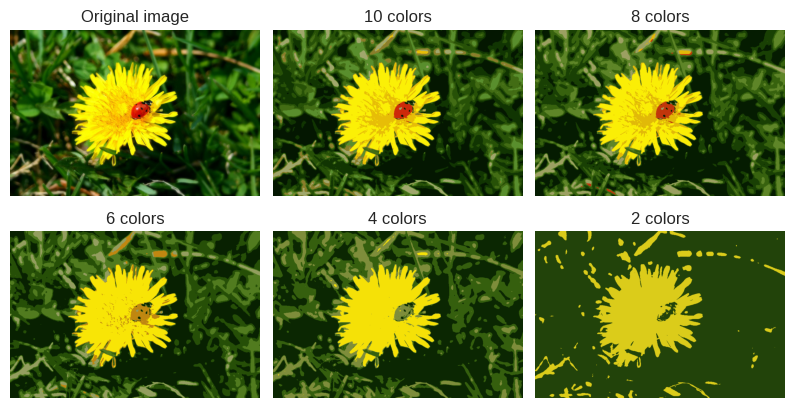

In [29]:
plt.figure(figsize=(10,5))
plt.subplots_adjust(wspace=0.05, hspace=0.1)

plt.subplot(231)
plt.imshow(image)
plt.title("Original image")
plt.axis('off')

for idx, n_clusters in enumerate(n_colors):
    plt.subplot(232 + idx)
    plt.imshow(segmented_imgs[idx])
    plt.title("{} colors".format(n_clusters))
    plt.axis('off')

plt.show()

## Using Clustering for Preprocessing

Clustering can be an efficient approach to dimensionality reduction, in particular as a preprocessing step before a supervised learning algorithm. As an example of using clustering for dimensionality reduction, let’s tackle the digits dataset, which is a simple MNIST-like dataset containing 1797 grayscale 8x8 images representing the digits 0 to 9. First, load the dataset:

In [30]:
from sklearn.datasets import load_digits
X_digits, y_digits = load_digits(return_X_y=True)

# Let's split it into a training set and a test set:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits, random_state=seed)

# Now let's fit a Logistic Regression model and evaluate it on the test set:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=seed)
log_reg.fit(X_train, y_train)

log_reg_score = log_reg.score(X_test, y_test)
log_reg_score

0.9688888888888889

In [31]:
# Let's take that as our baseline accuracy: 96.89%.
# Let's see if we can do better by using K-Means as a preprocessing step.
# We will create a pipeline that will first cluster the training set into 50 clusters and replace
# the images with their distances to the 50 clusters, then apply a logistic regression model:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ("kmeans", KMeans(n_clusters=50, random_state=seed)),
    ("log_reg", LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=seed)),
])
pipeline.fit(X_train, y_train)

# This pipeline is equivalent to: 
# kmeans = KMeans(n_clusters=50, random_state=seed)
# log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=seed)
# new_X_train = kmeans.fit_transform(X_train)
# log_reg.fit(new_X_train, y_train) 

# Thus `KMeans` is used to transform the training data. The original data, which has 64 features,
# is transformed into data with k features consisting of distances of the instances to the k centroids.
# This transformed data, together with the original labels, is then used to fit LogisticRegression.
# Prediction works the same way: the test data is first transformed by `KMeans` and then `LogisticRegression`
# is used with the transformed data to predict labels. Thus, instead of `pipeline.predict(X_test)` one
# could use `log_reg.predict(kmeans.transform(X_test))`

Pipeline(steps=[('kmeans', KMeans(n_clusters=50, random_state=42)),
                ('log_reg',
                 LogisticRegression(max_iter=5000, multi_class='ovr',
                                    random_state=42))])

In [32]:
pipeline_score = pipeline.score(X_test, y_test)
pipeline_score

0.9777777777777777

In [33]:
X_train

array([[ 0.,  0.,  2., ...,  0.,  0.,  0.],
       [ 0.,  5., 16., ...,  6.,  1.,  0.],
       [ 0.,  0.,  4., ...,  2.,  0.,  0.],
       ...,
       [ 0.,  0.,  9., ..., 16.,  2.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  1.,  0.,  0.]])

In [34]:
# We reduced the error from 3.1% to about 2.2%
# But we chose the number of clusters `k` completely arbitrarily, we can surely do better.
# Since K-Means is just a preprocessing step in a classification pipeline, finding a good
# value for `k` is much simpler now. The best value of `k` is simply the one that results
# in the best classification performance.

from sklearn.model_selection import 

# Warning: the following cell may take close to 10 minutes to run, or more depending on your hardware.
# param_grid = dict(kmeans__n_clusters=range(2, 100))
# grid_clf = GridSearchCV(pipeline, param_grid, cv=3, verbose=2,  n_jobs=-1)
# grid_clf.fit(X_train, y_train)

In [35]:
# Let's see what the best number of clusters is:

# grid_clf.best_params_

In [36]:
# grid_clf.score(X_test, y_test)

# Cool! With k = 99 clusters, we get a significant accuracy boost, reaching 98.22% accuracy on the test set.
# You may want to keep exploring higher values for k, since 99 was the largest value in the range we explored.